torch (PyTorch, un marco para aprendizaje automático) y cv2 (OpenCV, una biblioteca para visión por computadora). Luego, imprime la versión de PyTorch instalada para confirmar que está presente y verificar compatibilidad. Después, comprueba si hay una GPU con CUDA disponible para acelerar cálculos con PyTorch


In [6]:
import torch, cv2

print("Torch version:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))

print("OpenCV version:", cv2.__version__)


Torch version: 2.8.0+cu126
CUDA disponible: True
Dispositivo: NVIDIA GeForce RTX 3050 6GB Laptop GPU
OpenCV version: 4.10.0


In [7]:
# =======================
# CONFIG & ACELERADORES
# =======================
import os, math, time, json, random, glob
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2

# ---- reproducibilidad simple
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# ---- aceleradores seguros para RTX 3050
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


Tipo: <class 'numpy.ndarray'>
Imagen es None? False


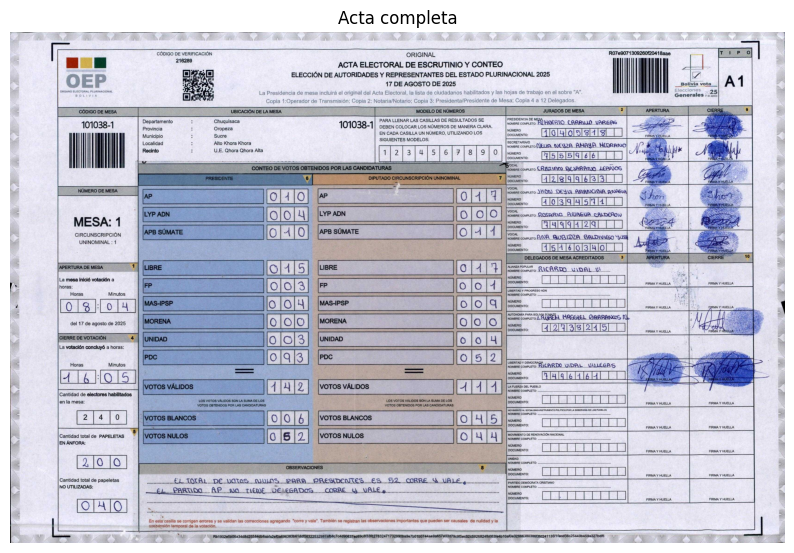

Tamaño imagen: (2200, 3336, 3)
ROI shape: (200, 200, 3)


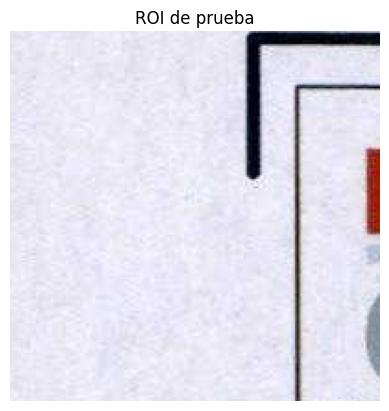

In [5]:
import cv2
import matplotlib.pyplot as plt

# ==== 1. Ruta del archivo (cambia esto a donde tengas tu acta) ====
ruta_img = "D:/POLLO/acta.jpg"   # <-- AJUSTA AQUÍ

# ==== 2. Cargar imagen ====
img = cv2.imread(ruta_img)

# Verificación
print("Tipo:", type(img))
print("Imagen es None?", img is None)

if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_img}")

# Convertir a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar imagen completa
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.title("Acta completa")
plt.axis("off")
plt.show()

print("Tamaño imagen:", img_rgb.shape)  # (alto, ancho, canales)

# ==== 3. Recorte de prueba (ROI) ====
# coordenadas dentro de la imagen (ejemplo arriba a la izquierda)
x, y, w, h = 50, 50, 200, 200

roi = img_rgb[y:y+h, x:x+w]
print("ROI shape:", roi.shape)

plt.imshow(roi)
plt.title("ROI de prueba")
plt.axis("off")
plt.show()


In [10]:
# =======================
# BLOQUE 2 — Anotar ROIs RELATIVOS (proporciones)
# =======================
import cv2, json, os

ruta_img = r"d:/POLLO/acta.jpg"     # tu plantilla/base
salida_rois = r"d:/POLLO/rois_rel.json"

img = cv2.imread(ruta_img)
if img is None:
    raise FileNotFoundError(ruta_img)
H, W = img.shape[:2]

# Para que sea cómodo anotar si es grande
target_w = 1000
scale = min(1.0, target_w / W)
img_small = cv2.resize(img, (int(W*scale), int(H*scale))) if scale != 1.0 else img

# Ajusta los campos a tu necesidad
casillas = [
    "mesa_numero","AP","LYP_ADN","APB_SUMATE","LIBRE","FP",
    "MAS_IPSP","MORENA","UNIDAD","PDC","BLANCOS","NULOS",
    "HABILITADOS","VALIDOS"  
]

rois_rel = {"__meta__":{"base_w": W, "base_h": H}, "boxes": {}}

for nombre in casillas:
    print(f"Selecciona ROI para: {nombre}  (ENTER=OK, ESC=cancel)")
    r = cv2.selectROI("Seleccionar ROI (escala)", img_small, fromCenter=False, showCrosshair=True)
    x,y,ww,hh = map(int, r)
    if ww <= 0 or hh <= 0:
        print(f"⚠️  ROI vacío para {nombre}, se omite.")
        continue
    # volver a tamaño original
    X = int(x/scale); Y = int(y/scale)
    Ww = int(ww/scale); Hh = int(hh/scale)
    # guardar en proporciones
    xr, yr, wr, hr = X/W, Y/H, Ww/W, Hh/H
    rois_rel["boxes"][nombre] = [xr, yr, wr, hr]

cv2.destroyAllWindows()

os.makedirs(os.path.dirname(salida_rois), exist_ok=True)
with open(salida_rois, "w", encoding="utf-8") as f:
    json.dump(rois_rel, f, indent=2, ensure_ascii=False)

print(f"✅ ROIs relativos guardados en {salida_rois}")


Selecciona ROI para: mesa_numero  (ENTER=OK, ESC=cancel)
Selecciona ROI para: AP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: AP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: LYP_ADN  (ENTER=OK, ESC=cancel)
Selecciona ROI para: LYP_ADN  (ENTER=OK, ESC=cancel)
Selecciona ROI para: APB_SUMATE  (ENTER=OK, ESC=cancel)
Selecciona ROI para: APB_SUMATE  (ENTER=OK, ESC=cancel)
Selecciona ROI para: LIBRE  (ENTER=OK, ESC=cancel)
Selecciona ROI para: LIBRE  (ENTER=OK, ESC=cancel)
Selecciona ROI para: FP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: FP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: MAS_IPSP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: MAS_IPSP  (ENTER=OK, ESC=cancel)
Selecciona ROI para: MORENA  (ENTER=OK, ESC=cancel)
Selecciona ROI para: MORENA  (ENTER=OK, ESC=cancel)
Selecciona ROI para: UNIDAD  (ENTER=OK, ESC=cancel)
Selecciona ROI para: UNIDAD  (ENTER=OK, ESC=cancel)
Selecciona ROI para: PDC  (ENTER=OK, ESC=cancel)
Selecciona ROI para: PDC  (ENTER=OK, ESC=cancel)
Selecciona ROI pa

In [11]:
# =======================
# BLOQUE 3 — Verificar ROIs RELATIVOS
# =======================
import cv2, json

with open(salida_rois, "r", encoding="utf-8") as f:
    rr = json.load(f)

img_vis = img.copy()
for k, (xr,yr,wr,hr) in rr["boxes"].items():
    x = int(xr*W); y = int(yr*H); ww = int(wr*W); hh = int(hr*H)
    cv2.rectangle(img_vis, (x,y), (x+ww,y+hh), (255,0,0), 2)
    cv2.putText(img_vis, k, (x, max(0,y-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

cv2.imwrite(r"d:/POLLO/rois_check.jpg", img_vis)
print("🖼️ Captura de verificación: d:/POLLO/rois_check.jpg")


🖼️ Captura de verificación: d:/POLLO/rois_check.jpg


In [6]:
# =======================
# TRAIN: ResNeXt50 + CRNN (CTC) — OPTIMIZADO + MONITOREO
# =======================
import os, re, csv, time, glob, random
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
import cv2

try:
    from tqdm import tqdm
except:
    tqdm = lambda x, **k: x  # fallback si no está instalado

# ------------------
# Config
# ------------------
DATA_TRAIN = r"D:\POLLO\data\train"
DATA_VAL   = r"D:\POLLO\data\val"
CKPT_BEST  = r"D:\POLLO\resnext_ocr_best.pt"
CKPT_LAST  = r"D:\POLLO\resnext_ocr_last.pt"
LOG_CSV    = r"D:\POLLO\train_log.csv"

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Entrenamiento
BATCH_SIZE = 16         # óptimo para VRAM media
EPOCHS     = 20         # más épocas para mejor precisión
WARMUP_EPOCHS = 2       # warmup lineal
LR_INIT    = 1e-3
WD         = 1e-4
CLIP_NORM  = 1.0
AMP        = True
CHANNELS_LAST = True
FREEZE_BACKBONE_EPOCHS = 3   # descongela desde la época 4
ACCUM_STEPS = 2              # simula batch mayor, más estable

# DataLoader
NUM_WORKERS = 0  # sin multiproceso para depuración
PIN_MEMORY = True
PERSISTENT_WORKERS = NUM_WORKERS > 0
PREFETCH_FACTOR = 4 if NUM_WORKERS>0 else None

# Alfabeto CTC
DIGITS    = "0123456789"
BLANK_IDX = 10
NCLASS    = 11

# OpenCV: evita exceso de threads
cv2.setNumThreads(0)

# CUDA knobs
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

# ------------------
# Utilidades
# ------------------
def encode_text_to_ints(txt: str):
    s = re.sub(r"[^0-9]", "", txt or "")
    return [int(c) for c in s]

def read_pairs(folder: str):
    pairs = []
    for label in os.listdir(folder):
        label_dir = os.path.join(folder, label)
        if not os.path.isdir(label_dir): continue
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for fp in glob.glob(os.path.join(label_dir, ext)):
                pairs.append((fp, label))
    return pairs

class DigitsSeqDataset(Dataset):
    def __init__(self, root_dir: str, train: bool=True, do_clean: bool=False):
        self.train = train
        self.do_clean = do_clean
        pairs = read_pairs(root_dir)
        self.samples = pairs

        self.tfm = T.Compose([
            T.ToPILImage(),
            T.Resize((32, 192)),   # secuencias 1–4 dígitos
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)
        ])

    def _clean_digits(self, bgr):
        # (desactivado por defecto en sintético; en real puede ayudar)
        g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        g = cv2.GaussianBlur(g,(3,3),0.5)
        thr = cv2.adaptiveThreshold(g,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,15)
        k = cv2.getStructuringElement(cv2.MORPH_RECT,(1,2))
        thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN, k, iterations=1)
        return cv2.cvtColor(thr, cv2.COLOR_GRAY2BGR)

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        fp, lab = self.samples[i]
        img = cv2.imread(fp)
        if img is None:
            img = np.zeros((32,192,3), np.uint8)
        if self.do_clean:
            img = self._clean_digits(img)
        x = self.tfm(img)
        tgt = torch.tensor(encode_text_to_ints(lab), dtype=torch.long)
        return x, tgt, fp

def ctc_collate(batch):
    xs, tgts, fps = zip(*batch)
    xs = torch.stack(xs,0)
    tgt_lens = torch.tensor([t.numel() for t in tgts], dtype=torch.long)
    flat = torch.tensor([], dtype=torch.long)
    if tgts and any(t.numel()>0 for t in tgts):
        flat = torch.cat([t for t in tgts if t.numel()>0], dim=0)
    return xs, flat, tgt_lens, list(fps)

# ------------------
# Modelo
# ------------------
class CRNNHead(nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)     # [B,C,W]
        x = x.permute(0,2,1)     # [B,W,C]
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)        # [B,T,nclass]

class ResNeXtOCR(nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])  # [B,2048,H',W']
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):   # logits [B,T,N] (log_softmax)
    pred = logits.argmax(-1)
    seqs=[]
    for p in pred:
        last=-1; s=[]
        for t in p.tolist():
            if t!=BLANK_IDX and t!=last: s.append(DIGITS[t])
            last=t
        seqs.append("".join(s))
    return seqs

def cer(ref, hyp):
    R, H = len(ref), len(hyp)
    if R == 0: return 0.0 if H==0 else 1.0
    dp = np.arange(H+1)
    for i in range(1, R+1):
        prev, dp[0] = dp[0], i
        for j in range(1, H+1):
            cur = min(dp[j]+1, dp[j-1]+1, prev + (ref[i-1] != hyp[j-1]))
            prev, dp[j] = dp[j], cur
    return dp[H]/max(1,R)

# ------------------
# Data
# ------------------
train_ds = DigitsSeqDataset(DATA_TRAIN, train=True,  do_clean=False)  # sintético => False
val_ds   = DigitsSeqDataset(DATA_VAL,   train=False, do_clean=False)

assert len(train_ds)>0, "Sin muestras etiquetadas en TRAIN."
assert len(val_ds)>0,   "Sin muestras etiquetadas en VAL."

dl_kwargs = dict(batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                 persistent_workers=PERSISTENT_WORKERS, collate_fn=ctc_collate)
if NUM_WORKERS>0:
    dl_kwargs.update(num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR)

train_dl = DataLoader(train_ds, shuffle=True,  drop_last=True,  **dl_kwargs)
val_dl   = DataLoader(val_ds,   shuffle=False, drop_last=False, **dl_kwargs)

print(f"train: {len(train_ds)} | val: {len(val_ds)}")
print("Torch:", torch.__version__,
      "| CUDA:", torch.cuda.is_available(),
      "| Device:", (torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"),
      "| cuDNN:", torch.backends.cudnn.version())

# ------------------
# Modelo + Optimizador + Schedulers
# ------------------
model = ResNeXtOCR().to(DEVICE)
if CHANNELS_LAST: model = model.to(memory_format=torch.channels_last)

# OPCIONAL: compilar (PyTorch 2.x). Primer epoch puede tardar más por compile.
USE_COMPILE = False
if USE_COMPILE and hasattr(torch, "compile"):
    model = torch.compile(model, mode="reduce-overhead")  # o "max-autotune"

ctc_loss = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
opt = torch.optim.AdamW(model.parameters(), lr=LR_INIT, weight_decay=WD)

# Warmup + Cosine
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
sched = SequentialLR(
    opt,
    schedulers=[
        LinearLR(opt, start_factor=0.1, end_factor=1.0, total_iters=max(1, WARMUP_EPOCHS)),
        CosineAnnealingLR(opt, T_max=max(1, EPOCHS-WARMUP_EPOCHS), eta_min=LR_INIT*0.05)
    ],
    milestones=[max(1, WARMUP_EPOCHS)]
)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)

best_em = -1.0
if not os.path.exists(LOG_CSV):
    with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(["epoch","lr","train_loss","val_em","val_cer","sec","gpu_peak_GB"])

print("Modelo en:", next(model.parameters()).device)

# ---- Burn test (ver GPU) opcional ----
DO_BURN = False
if DO_BURN:
    x = torch.randn(BATCH_SIZE, 3, 32, 192, device=DEVICE)
    if CHANNELS_LAST: x = x.to(memory_format=torch.channels_last)
    y = model(x).sum()
    y.backward()
    for _ in range(20):
        opt.zero_grad(set_to_none=True)
        y = model(x).sum(); y.backward()
        torch.cuda.synchronize()
    print("✓ Burn test (GPU) ok")

# ------------------
# Loop
# ------------------
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # freeze / unfreeze backbone
    if epoch <= FREEZE_BACKBONE_EPOCHS:
        for p in model.backbone.parameters(): p.requires_grad_(False)
    else:
        for p in model.backbone.parameters(): p.requires_grad_(True)

    model.train()
    torch.cuda.reset_peak_memory_stats()
    running = 0.0
    step_accum = 0

    pbar = tqdm(enumerate(train_dl, 1), total=len(train_dl), desc=f"Epoch {epoch}/{EPOCHS}")
    for i, (imgs, flat_targets, target_lengths, paths) in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        if CHANNELS_LAST: imgs = imgs.to(memory_format=torch.channels_last)
        flat_targets  = flat_targets.to(DEVICE, non_blocking=True)
        target_lengths= target_lengths.to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=AMP):
            logits = model(imgs).log_softmax(-1)         # [B,T,N]
            B,T,N = logits.shape
            input_lengths = torch.full((B,), T, dtype=torch.long, device=DEVICE)
            loss = ctc_loss(logits.permute(1,0,2), flat_targets, input_lengths, target_lengths) / ACCUM_STEPS

        scaler.scale(loss).backward()
        step_accum += 1
        if step_accum % ACCUM_STEPS == 0:
            if CLIP_NORM is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        running += loss.item() * ACCUM_STEPS
        if i == 1:
            with torch.no_grad():
                out = model(imgs).detach()
            pbar.set_postfix({
                "loss": f"{running/i:.4f}",
                "dev": str(out.device),
                "mem(G)": f"{torch.cuda.memory_allocated()/1e9:.2f}" if torch.cuda.is_available() else "CPU"
            })
        elif i % 50 == 0:
            img_per_s = BATCH_SIZE * 50 / (time.time() - t0 + 1e-6)
            pbar.set_postfix({
                "loss": f"{running/i:.4f}",
                "imgs/s": f"{img_per_s:.1f}",
                "mem(G)": f"{torch.cuda.memory_allocated()/1e9:.2f}" if torch.cuda.is_available() else "CPU"
            })

    sched.step()

    # ---- Eval ----
    model.eval()
    total=0; exact=0; cer_sum=0.0
    with torch.no_grad():
        for imgs, flat_targets, target_lengths, paths in val_dl:
            imgs = imgs.to(DEVICE, non_blocking=True)
            if CHANNELS_LAST: imgs = imgs.to(memory_format=torch.channels_last)
            logits = model(imgs).log_softmax(-1)         # [B,T,N]
            preds = ctc_greedy_decode(logits.cpu())

            idx=0; gts=[]
            for L in target_lengths.tolist():
                seq = flat_targets[idx:idx+L].tolist(); idx+=L
                gt = "".join(DIGITS[k] for k in seq)
                gts.append(gt)

            for p,g in zip(preds,gts):
                if g=="": continue
                total += 1
                exact += int(p==g)
                cer_sum += cer(g,p)

    val_em = (exact/total) if total>0 else 0.0
    val_cer = (cer_sum/total) if total>0 else 0.0
    dt = time.time()-t0
    lr_now = sched.get_last_lr()[0]
    peak_gb = torch.cuda.max_memory_allocated()/1e9 if torch.cuda.is_available() else 0.0

    print(f"Epoch {epoch} | lr={lr_now:.5f} | train_loss={running/len(train_dl):.4f} | "
          f"val_EM={val_em:.4f} | val_CER={val_cer:.4f} | {dt:.1f}s | peak_mem={peak_gb:.2f}G")

    # log y checkpoints
    with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([epoch, lr_now, running/len(train_dl), val_em, val_cer, round(dt,2), round(peak_gb,2)])

    torch.save(model.state_dict(), CKPT_LAST)
    if val_em > best_em:
        best_em = val_em
        torch.save(model.state_dict(), CKPT_BEST)
        print("✓ Guardado BEST checkpoint")

print("Entrenamiento finalizado. Best EM:", round(best_em,4))

train: 4206 | val: 69
Torch: 2.8.0+cu126 | CUDA: True | Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU | cuDNN: 91002


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_11916\4033376117.py:220: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP)


Modelo en: cuda:0


Epoch 1/20:   0%|          | 0/262 [00:00<?, ?it/s]C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_11916\4033376117.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_11916\4033376117.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
Epoch 1/20: 100%|██████████| 262/262 [01:23<00:00,  3.13it/s, loss=3.3233, imgs/s=9.9, mem(G)=0.19] 



Epoch 1 | lr=0.00055 | train_loss=3.2633 | val_EM=0.1014 | val_CER=0.8986 | 95.0s | peak_mem=5.08G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 2/20: 100%|██████████| 262/262 [00:16<00:00, 16.28it/s, loss=1.6446, imgs/s=52.1, mem(G)=0.19] 
d:\POLLO\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)

d:\POLLO\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where a

Epoch 2 | lr=0.00100 | train_loss=1.6276 | val_EM=0.2754 | val_CER=0.7246 | 16.2s | peak_mem=0.27G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 3/20: 100%|██████████| 262/262 [00:15<00:00, 16.47it/s, loss=1.4673, imgs/s=52.7, mem(G)=0.19] 



Epoch 3 | lr=0.00099 | train_loss=1.4639 | val_EM=0.2464 | val_CER=0.7536 | 16.0s | peak_mem=0.27G


Epoch 4/20: 100%|██████████| 262/262 [00:43<00:00,  6.00it/s, loss=1.1501, imgs/s=19.0, mem(G)=0.38]



Epoch 4 | lr=0.00097 | train_loss=1.1560 | val_EM=0.4058 | val_CER=0.5942 | 43.8s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 5/20: 100%|██████████| 262/262 [00:35<00:00,  7.47it/s, loss=0.8067, imgs/s=23.9, mem(G)=0.38]



Epoch 5 | lr=0.00094 | train_loss=0.7999 | val_EM=0.6232 | val_CER=0.3768 | 35.2s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 6/20: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s, loss=0.5763, imgs/s=24.0, mem(G)=0.38]



Epoch 6 | lr=0.00089 | train_loss=0.5730 | val_EM=0.6667 | val_CER=0.3333 | 35.1s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 7/20: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s, loss=0.4621, imgs/s=24.0, mem(G)=0.38]



Epoch 7 | lr=0.00083 | train_loss=0.4590 | val_EM=0.7246 | val_CER=0.2754 | 35.1s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 8/20: 100%|██████████| 262/262 [00:37<00:00,  7.04it/s, loss=0.3871, imgs/s=22.5, mem(G)=0.38]



Epoch 8 | lr=0.00076 | train_loss=0.3830 | val_EM=0.7971 | val_CER=0.2029 | 37.3s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 9/20: 100%|██████████| 262/262 [00:35<00:00,  7.48it/s, loss=0.3037, imgs/s=23.9, mem(G)=0.38]



Epoch 9 | lr=0.00069 | train_loss=0.3059 | val_EM=0.7246 | val_CER=0.2754 | 35.1s | peak_mem=0.71G


Epoch 10/20: 100%|██████████| 262/262 [00:35<00:00,  7.47it/s, loss=0.2178, imgs/s=23.9, mem(G)=0.38]



Epoch 10 | lr=0.00061 | train_loss=0.2202 | val_EM=0.8116 | val_CER=0.1884 | 35.2s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 11/20: 100%|██████████| 262/262 [00:35<00:00,  7.47it/s, loss=0.1614, imgs/s=23.9, mem(G)=0.38]



Epoch 11 | lr=0.00052 | train_loss=0.1638 | val_EM=0.8551 | val_CER=0.1449 | 35.2s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 12/20: 100%|██████████| 262/262 [00:35<00:00,  7.48it/s, loss=0.1373, imgs/s=23.9, mem(G)=0.38]



Epoch 12 | lr=0.00044 | train_loss=0.1389 | val_EM=0.8841 | val_CER=0.1159 | 35.1s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 13/20: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s, loss=0.0842, imgs/s=24.0, mem(G)=0.38]



Epoch 13 | lr=0.00036 | train_loss=0.0833 | val_EM=0.9420 | val_CER=0.0580 | 35.1s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 14/20: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s, loss=0.0543, imgs/s=24.0, mem(G)=0.38]



Epoch 14 | lr=0.00029 | train_loss=0.0562 | val_EM=0.8841 | val_CER=0.1159 | 35.1s | peak_mem=0.71G


Epoch 15/20: 100%|██████████| 262/262 [00:34<00:00,  7.50it/s, loss=0.0432, imgs/s=24.0, mem(G)=0.38]



Epoch 15 | lr=0.00022 | train_loss=0.0418 | val_EM=0.9130 | val_CER=0.0870 | 35.0s | peak_mem=0.71G


Epoch 16/20: 100%|██████████| 262/262 [00:35<00:00,  7.49it/s, loss=0.0317, imgs/s=24.0, mem(G)=0.38]



Epoch 16 | lr=0.00016 | train_loss=0.0323 | val_EM=0.9565 | val_CER=0.0435 | 35.1s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 17/20: 100%|██████████| 262/262 [00:35<00:00,  7.47it/s, loss=0.0169, imgs/s=23.9, mem(G)=0.38]



Epoch 17 | lr=0.00011 | train_loss=0.0180 | val_EM=0.9710 | val_CER=0.0290 | 35.2s | peak_mem=0.71G
✓ Guardado BEST checkpoint
✓ Guardado BEST checkpoint


Epoch 18/20: 100%|██████████| 262/262 [00:35<00:00,  7.48it/s, loss=0.0119, imgs/s=23.9, mem(G)=0.38]



Epoch 18 | lr=0.00008 | train_loss=0.0117 | val_EM=0.9710 | val_CER=0.0290 | 35.1s | peak_mem=0.71G


Epoch 19/20: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s, loss=0.0086, imgs/s=24.0, mem(G)=0.38]



Epoch 19 | lr=0.00006 | train_loss=0.0118 | val_EM=0.9420 | val_CER=0.0580 | 35.1s | peak_mem=0.71G


Epoch 20/20: 100%|██████████| 262/262 [00:36<00:00,  7.21it/s, loss=0.0114, imgs/s=23.1, mem(G)=0.38]



Epoch 20 | lr=0.00005 | train_loss=0.0110 | val_EM=0.9420 | val_CER=0.0580 | 36.5s | peak_mem=0.71G
Entrenamiento finalizado. Best EM: 0.971


=== INICIO BLOQUE INFERENCIA ===
Cargando modelo desde: D:\POLLO\resnext_ocr_best.pt
Carpetas encontradas en VAL: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Carpeta: 0 | Imágenes encontradas: 7

=== Ejemplos aleatorios para dígito: 0 ===
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num13.jpg
Predicción: 0
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num19.jpg
Predicción: 0
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num15.jpg
Predicción: 0
Carpetas encontradas en VAL: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Carpeta: 0 | Imágenes encontradas: 7

=== Ejemplos aleatorios para dígito: 0 ===
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num13.jpg
Predicción: 0
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num19.jpg
Predicción: 0
Procesando archivo: D:\POLLO\data\val\0\mesa_1_1000241_num15.jpg
Predicción: 0


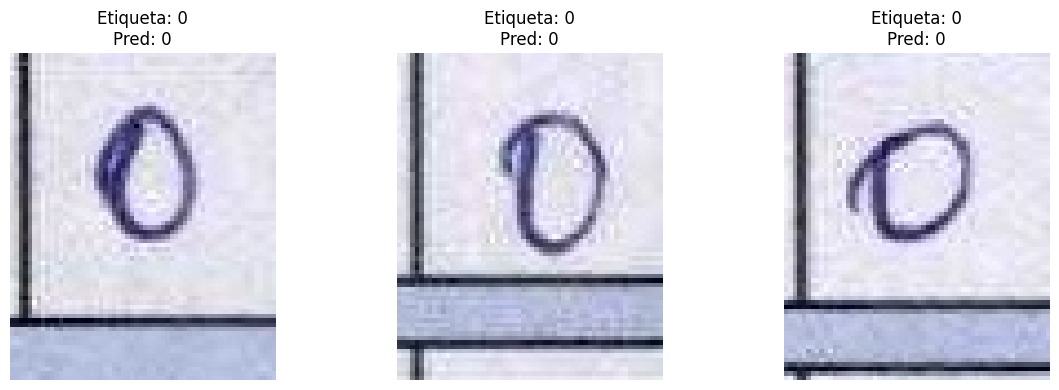

Carpeta: 1 | Imágenes encontradas: 8

=== Ejemplos aleatorios para dígito: 1 ===
Procesando archivo: D:\POLLO\data\val\1\mesa_1_1000291_num13.jpg
Predicción: 1
Procesando archivo: D:\POLLO\data\val\1\mesa_1_1000211_num30.jpg
Predicción: 1
Procesando archivo: D:\POLLO\data\val\1\mesa_1_1000321_num17.jpg
Predicción: 1


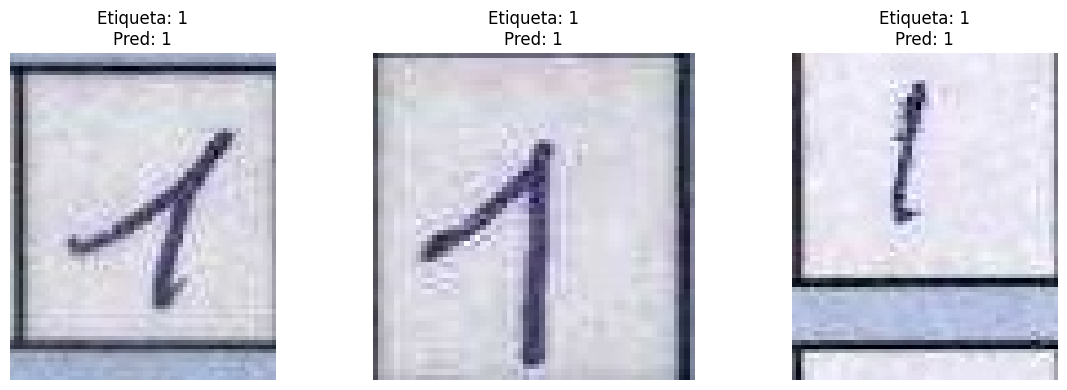

Carpeta: 2 | Imágenes encontradas: 4

=== Ejemplos aleatorios para dígito: 2 ===
Procesando archivo: D:\POLLO\data\val\2\mesa_1_1000021_num27.jpg
Predicción: 2
Procesando archivo: D:\POLLO\data\val\2\mesa_1_1000111_num11.jpg
Predicción: 2
Procesando archivo: D:\POLLO\data\val\2\mesa_1_1000151_num23.jpg
Predicción: 2
Predicción: 2


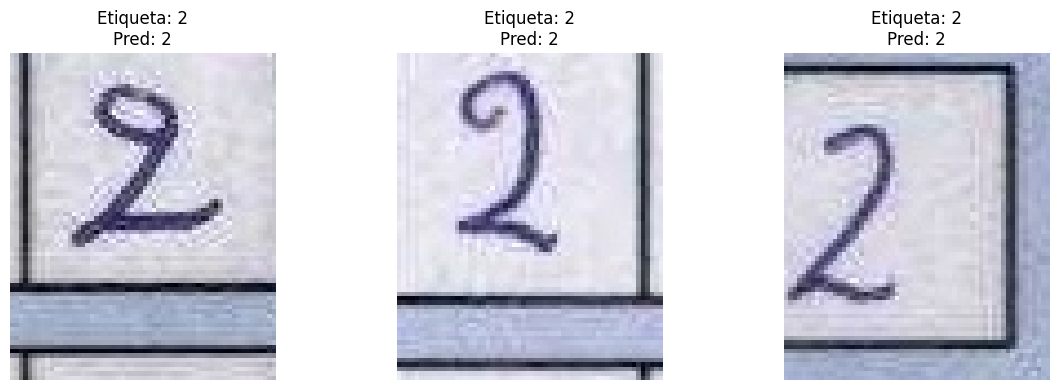

Carpeta: 3 | Imágenes encontradas: 8

=== Ejemplos aleatorios para dígito: 3 ===
Procesando archivo: D:\POLLO\data\val\3\mesa_1_1000151_num26.jpg
Predicción: 3
Procesando archivo: D:\POLLO\data\val\3\mesa_1_1000211_num21.jpg
Predicción: 0
Procesando archivo: D:\POLLO\data\val\3\mesa_1_1000041_num23.jpg
Predicción: 3


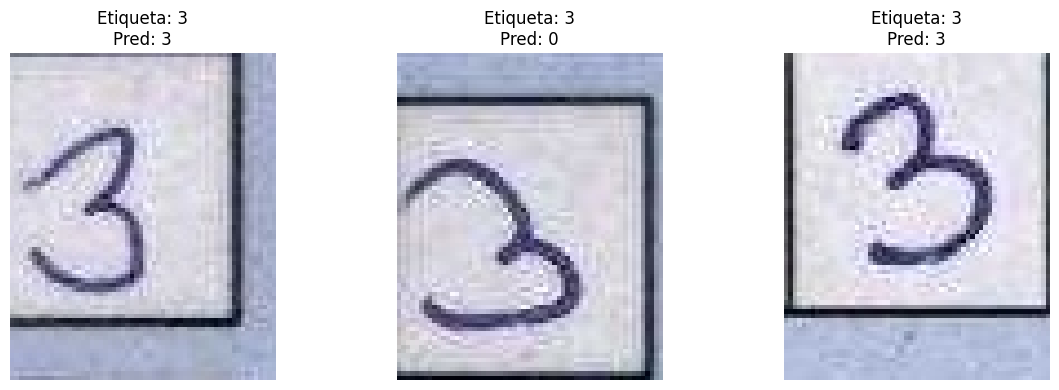

Carpeta: 4 | Imágenes encontradas: 7

=== Ejemplos aleatorios para dígito: 4 ===
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013591_num30.jpg
Predicción: 4
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013541_num15.jpg
Predicción: 4
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013591_num15.jpg
Predicción: 4
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013591_num30.jpg
Predicción: 4
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013541_num15.jpg
Predicción: 4
Procesando archivo: D:\POLLO\data\val\4\mesa_1_1013591_num15.jpg
Predicción: 4


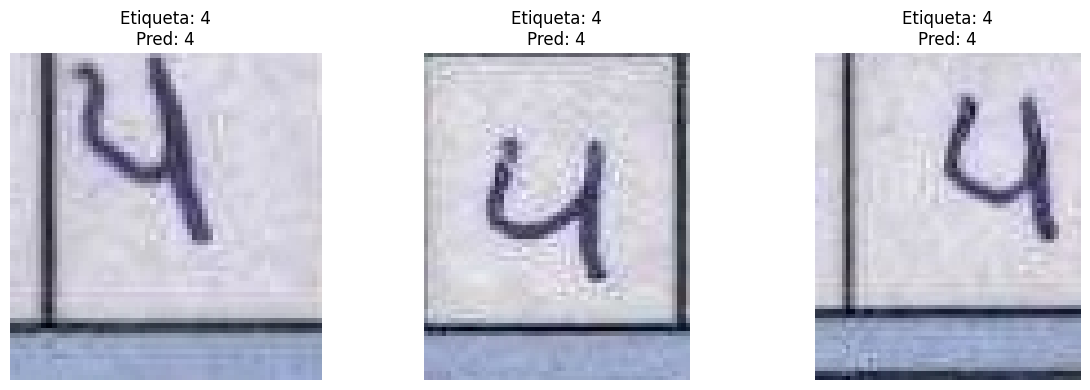

Carpeta: 5 | Imágenes encontradas: 7

=== Ejemplos aleatorios para dígito: 5 ===
Procesando archivo: D:\POLLO\data\val\5\mesa_1_1013601_num25.jpg
Predicción: 5
Procesando archivo: D:\POLLO\data\val\5\mesa_1_1013761_num11.jpg
Predicción: 5
Procesando archivo: D:\POLLO\data\val\5\mesa_1_1013961_num26.jpg
Predicción: 5
Predicción: 5
Procesando archivo: D:\POLLO\data\val\5\mesa_1_1013961_num26.jpg
Predicción: 5


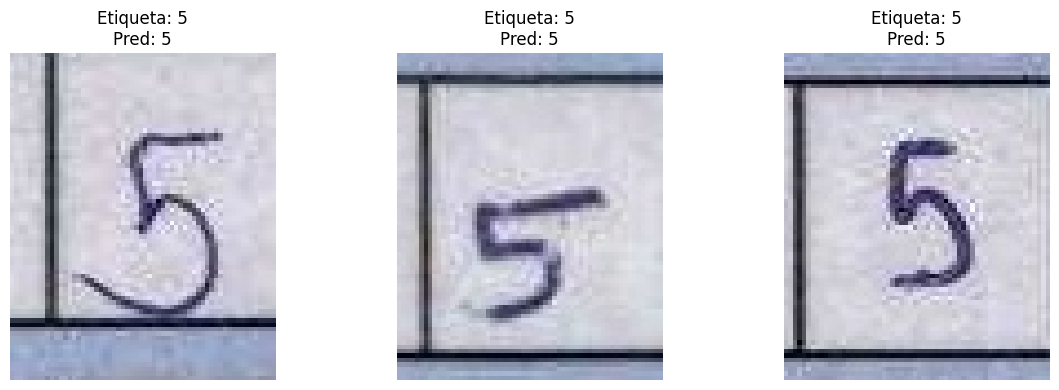

Carpeta: 6 | Imágenes encontradas: 5

=== Ejemplos aleatorios para dígito: 6 ===
Procesando archivo: D:\POLLO\data\val\6\mesa_1_1015811_num27.jpg
Predicción: 6
Procesando archivo: D:\POLLO\data\val\6\mesa_1_1015361_num30.jpg
Predicción: 6
Procesando archivo: D:\POLLO\data\val\6\mesa_1_1015571_num30.jpg
Predicción: 6


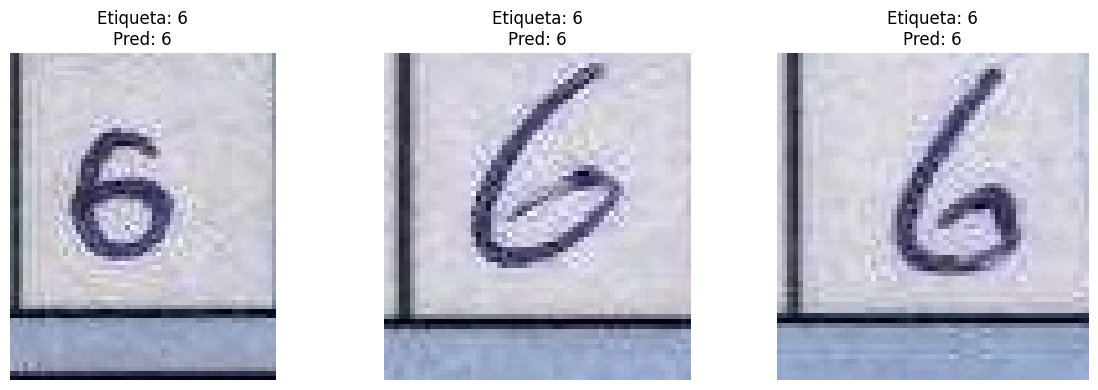

Carpeta: 7 | Imágenes encontradas: 8

=== Ejemplos aleatorios para dígito: 7 ===
Procesando archivo: D:\POLLO\data\val\7\mesa_3_1013241_num23.jpg
Predicción: 7
Procesando archivo: D:\POLLO\data\val\7\mesa_11_1017631_num25.jpg
Predicción: 7
Procesando archivo: D:\POLLO\data\val\7\mesa_10_1006851_num25.jpg
Predicción: 7


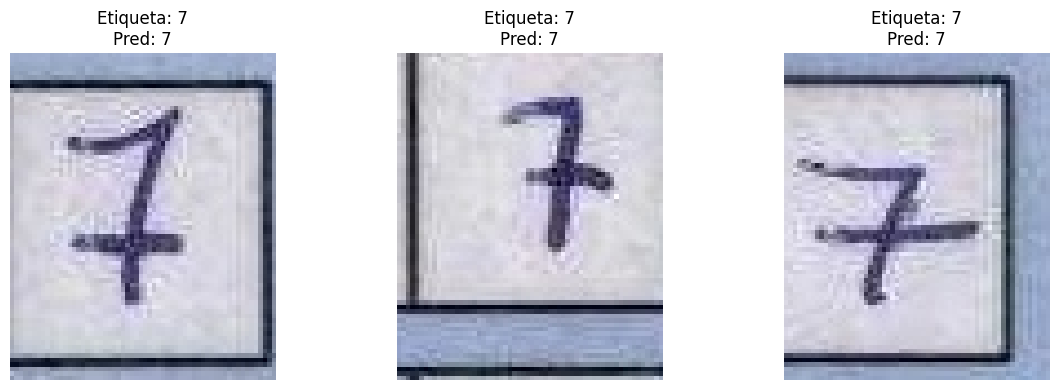

Carpeta: 8 | Imágenes encontradas: 8

=== Ejemplos aleatorios para dígito: 8 ===
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012571_num30.jpg
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012571_num30.jpg
Predicción: 8
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012441_num30.jpg
Predicción: 8
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012761_num23.jpg
Predicción: 8
Predicción: 8
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012441_num30.jpg
Predicción: 8
Procesando archivo: D:\POLLO\data\val\8\mesa_1_8012761_num23.jpg
Predicción: 8


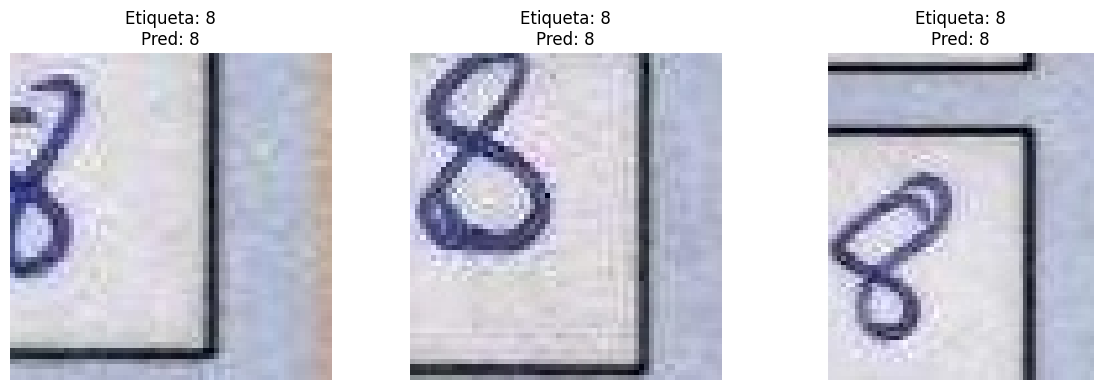

Carpeta: 9 | Imágenes encontradas: 7

=== Ejemplos aleatorios para dígito: 9 ===
Procesando archivo: D:\POLLO\data\val\9\mesa_1_8012932_num29.jpg
Predicción: 9
Procesando archivo: D:\POLLO\data\val\9\mesa_1_8013561_num23.jpg
Predicción: 9
Procesando archivo: D:\POLLO\data\val\9\mesa_1_8012921_num29.jpg
Predicción: 9


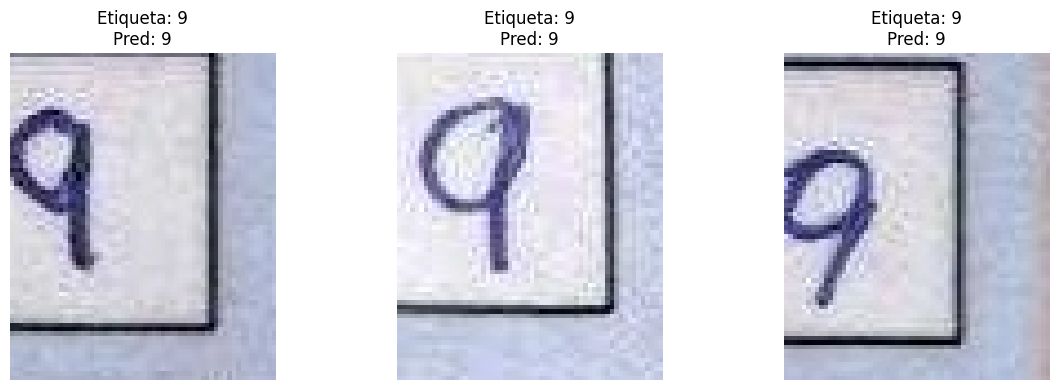

=== FIN BLOQUE INFERENCIA ===


In [15]:
import torch, cv2, os, glob, random
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

print("=== INICIO BLOQUE INFERENCIA ===")

# --- Configuración ---
DATA_VAL = r"D:\POLLO\data\val"
CKPT_BEST = r"D:\POLLO\resnext_ocr_best.pt"
DIGITS = "0123456789"
BLANK_IDX = 10
NCLASS = 11
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Modelo ---
class CRNNHead(torch.nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = torch.nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = torch.nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = torch.nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)
        x = x.permute(0,2,1)
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)

class ResNeXtOCR(torch.nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = torch.nn.Sequential(*list(base.children())[:-2])
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):
    pred = logits.argmax(-1)
    seqs = []
    for p in pred:
        last = -1; s = []
        for t in p.tolist():
            if t != BLANK_IDX and t != last: s.append(DIGITS[t])
            last = t
        seqs.append("".join(s))
    return seqs

# --- Transformación igual que en entrenamiento ---
tfm = T.Compose([
    T.ToPILImage(),
    T.Resize((32, 192)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# --- Cargar modelo ---
print(f"Cargando modelo desde: {CKPT_BEST}")
model = ResNeXtOCR().to(DEVICE)
model.load_state_dict(torch.load(CKPT_BEST, map_location=DEVICE))
model.eval()

# --- Mostrar ejemplos random en un grid ---
n_ejemplos = 3  # cuántas imágenes por dígito mostrar

digit_folders = [d for d in sorted(os.listdir(DATA_VAL)) if os.path.isdir(os.path.join(DATA_VAL, d))]
print(f"Carpetas encontradas en VAL: {digit_folders}")
if not digit_folders:
    print("No se encontraron carpetas de dígitos en la ruta de validación.")

for digit in digit_folders:
    digit_dir = os.path.join(DATA_VAL, digit)
    img_paths = glob.glob(os.path.join(digit_dir, "*.jpg"))
    print(f"Carpeta: {digit} | Imágenes encontradas: {len(img_paths)}")
    if not img_paths:
        print(f"No hay imágenes en la carpeta {digit}")
        continue
    
    print(f"\n=== Ejemplos aleatorios para dígito: {digit} ===")

    # elegir n_ejemplos random o menos si no hay tantas imágenes
    selected_paths = random.sample(img_paths, min(n_ejemplos, len(img_paths)))

    # preparar grid
    fig, axes = plt.subplots(1, len(selected_paths), figsize=(12, 4))
    if len(selected_paths) == 1:
        axes = [axes]  # asegurar iterabilidad
    
    for ax, fp in zip(axes, selected_paths):
        print(f"Procesando archivo: {fp}")
        img = cv2.imread(fp)
        if img is None:
            print(f"No se pudo leer: {fp}")
            continue
        x = tfm(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x).log_softmax(-1)
            pred = ctc_greedy_decode(logits.cpu())[0]
        print(f"Predicción: {pred}")
        
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Etiqueta: {digit}\nPred: {pred}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

print("=== FIN BLOQUE INFERENCIA ===")


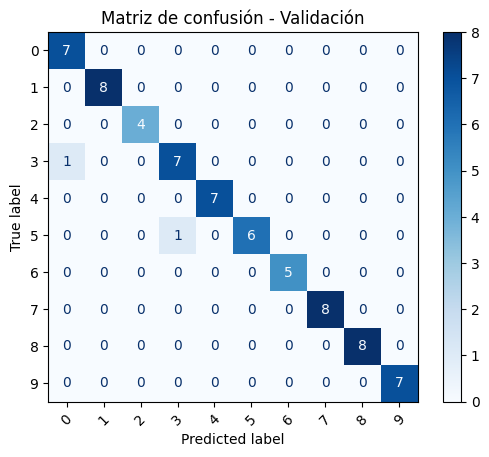


=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.88      0.88      0.88         8
           4       1.00      1.00      1.00         7
           5       1.00      0.86      0.92         7
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         7

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

Accuracy para dígito 0: 100.00%
Accuracy para dígito 1: 100.00%
Accuracy para dígito 2: 100.00%
Accuracy para dígito 3: 87.50%
Accuracy para dígito 4: 100.00%
Accuracy para dígito 5: 85.71%
Accuracy para díg

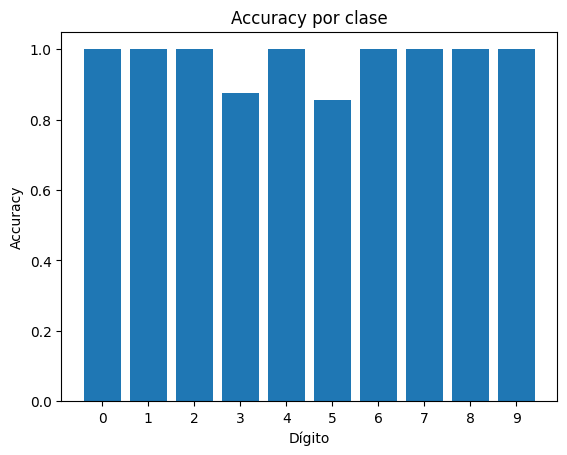


Total de errores: 2


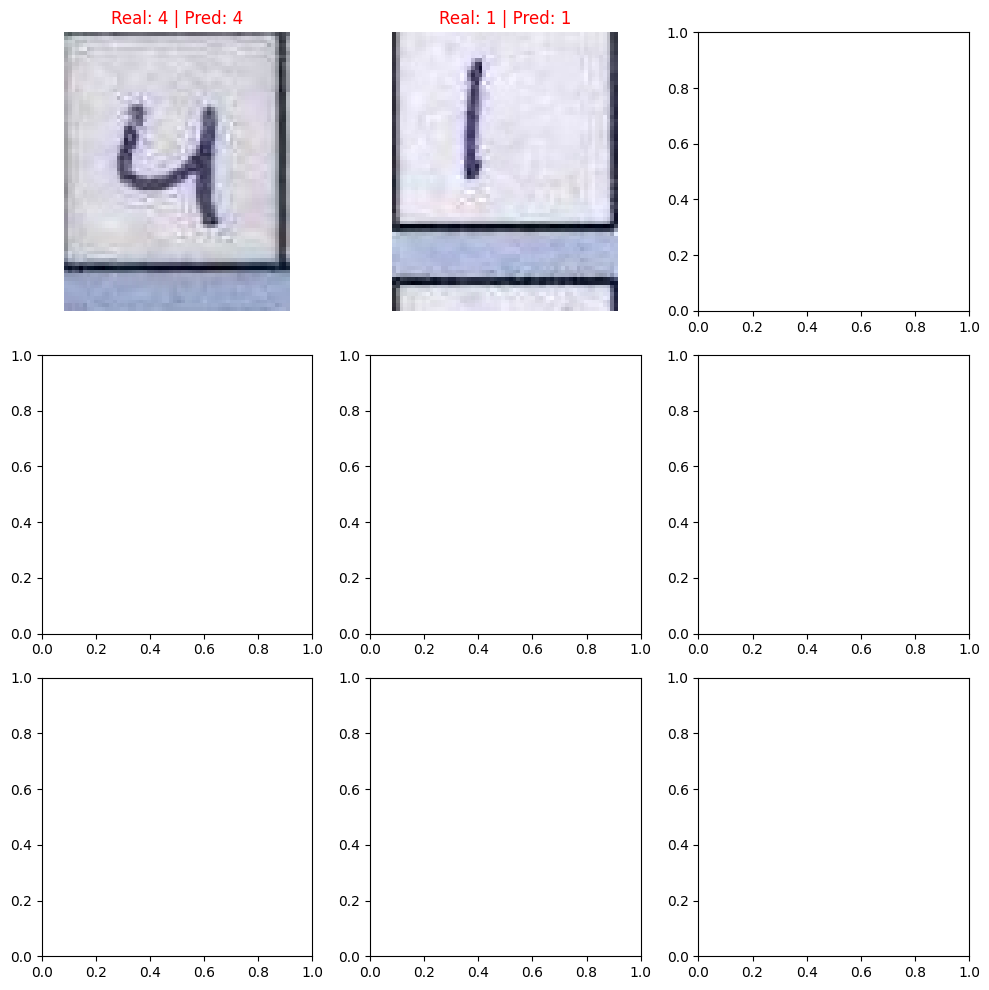

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# ==============================
# BLOQUE DE EVALUACIÓN
# ==============================

y_true = []
y_pred = []

for digit in digit_folders:
    digit_dir = os.path.join(DATA_VAL, digit)
    img_paths = glob.glob(os.path.join(digit_dir, "*.jpg"))

    for fp in img_paths:
        img = cv2.imread(fp)
        if img is None:
            continue
        x = tfm(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x).log_softmax(-1)
            pred = ctc_greedy_decode(logits.cpu())[0]

        # --- Guardar etiquetas reales y predichas ---
        if digit.isdigit():
            y_true.append(int(digit))  # etiqueta real
            y_pred.append(int(pred) if pred.isdigit() else -1)  # -1 = fallo

# Convertir a numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------
# 1. Matriz de confusión
# -------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(DIGITS))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Validación")
plt.show()

# -------------------------
# 2. Reporte de métricas
# -------------------------
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_true, y_pred, labels=list(range(10)), target_names=list(DIGITS)))

# -------------------------
# 3. Accuracy por clase
# -------------------------
accs = []
for i in range(10):
    mask = (y_true == i)
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_true[mask]).mean()
        accs.append(acc)
        print(f"Accuracy para dígito {i}: {acc:.2%}")

plt.bar(range(10), accs)
plt.xticks(range(10), DIGITS)
plt.title("Accuracy por clase")
plt.xlabel("Dígito")
plt.ylabel("Accuracy")
plt.show()

# -------------------------
# 4. Mostrar errores
# -------------------------
errores = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
print(f"\nTotal de errores: {len(errores)}")

if errores:
    # Elegir algunos errores aleatorios
    muestra = random.sample(list(zip(y_true, y_pred)), min(9, len(errores)))
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    for ax, (t, p) in zip(axes, muestra):
        # Recuperar imagen que causó el error
        digit_dir = os.path.join(DATA_VAL, str(t))
        imgs = glob.glob(os.path.join(digit_dir, "*.jpg"))
        if not imgs: continue
        fp = random.choice(imgs)
        img = cv2.imread(fp)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Real: {t} | Pred: {p}", color="red")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


📝 Explicación del bloque de predicción y segmentación

Este bloque se encarga de interpretar los ROIs (regiones de interés) de la imagen del acta electoral y extraer los dígitos que contienen (ya sea número de mesa, votos por partido, etc.).

In [42]:
import numpy as np
import cv2

# --- Segmentación por contornos (ideal para 'mesa_numero') ---
def segment_digits_contours(roi, min_h_ratio=0.45, min_w_px=6, pad=2):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # binarización robusta
    _ , th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = th.shape
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        # filtrar ruido: alto suficiente y ancho mínimo
        if h >= min_h_ratio * H and w >= min_w_px:
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])  # izquierda -> derecha

    crops = []
    for (x, y, w, h) in boxes:
        x0 = max(x - pad, 0); y0 = max(y - pad, 0)
        x1 = min(x + w + pad, W); y1 = min(y + h + pad, H)
        crops.append(roi[y0:y1, x0:x1])
    return crops

# --- Respaldo por proyección vertical (vales/gaps entre dígitos) ---
def segment_digits_projection(roi, gap_frac=0.03, min_w_frac=0.05, pad=2):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _ , th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    H, W = th.shape
    col_sum = (th > 0).sum(axis=0).astype(np.int32)
    # umbral para considerar "gap" entre dígitos
    gap_thr = max(1, int(gap_frac * H))
    gaps = col_sum <= gap_thr

    # detectar segmentos conectados (no-gap)
    segments = []
    in_seg = False; s = 0
    for i, g in enumerate(gaps):
        if not g and not in_seg:
            in_seg = True; s = i
        if (g or i == W - 1) and in_seg:
            e = i if g else i + 1
            segments.append((s, e))
            in_seg = False

    # limpiar segmentos muy estrechos
    min_w = max(3, int(min_w_frac * W))
    segments = [(s, e) for s, e in segments if (e - s) >= min_w]

    crops = []
    for s, e in segments:
        x0 = max(s - pad, 0); x1 = min(e + pad, W)
        y0 = 0; y1 = H
        crops.append(roi[y0:y1, x0:x1])
    return crops

# --- Predicción para ROI con N casillas fijas ---
def predict_fixed_boxes(roi, ndig: int):
    H, W = roi.shape[:2]
    ancho = max(1, W // ndig)
    out = ""
    for i in range(ndig):
        sub = roi[:, i*ancho:(i+1)*ancho]
        if sub.size == 0:
            continue
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            out += ctc_greedy_decode(logits.cpu())[0]
    return out

# --- Predicción para ROI con dígitos juntos (sin casillas) ---
def predict_sequence_roi(roi):
    # 1) intentar contornos
    crops = segment_digits_contours(roi)
    # 2) si no encuentra nada razonable, usar proyección vertical
    if len(crops) == 0:
        crops = segment_digits_projection(roi)
    # 3) si aún nada, como último recurso pasar ROI completo (puede dar 1 dígito)
    if len(crops) == 0:
        crops = [roi]

    out = ""
    for sub in crops:
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            out += ctc_greedy_decode(logits.cpu())[0]
    return out

# --- Router por campo ---
# Ajusta este set con los campos que NO tienen casillas:
SEQ_FIELDS = {"mesa_numero"}  # p.ej. "acta_id", etc.

# Si todas las otras cajas tienen 3 casillas, puedes dejar 3 por defecto.
DEFAULT_BOXES_PER_FIELD = 3

def predict_field(nombre, roi):
    if roi.size == 0:
        return ""
    if nombre in SEQ_FIELDS:
        return predict_sequence_roi(roi)
    else:
        return predict_fixed_boxes(roi, ndig=DEFAULT_BOXES_PER_FIELD)


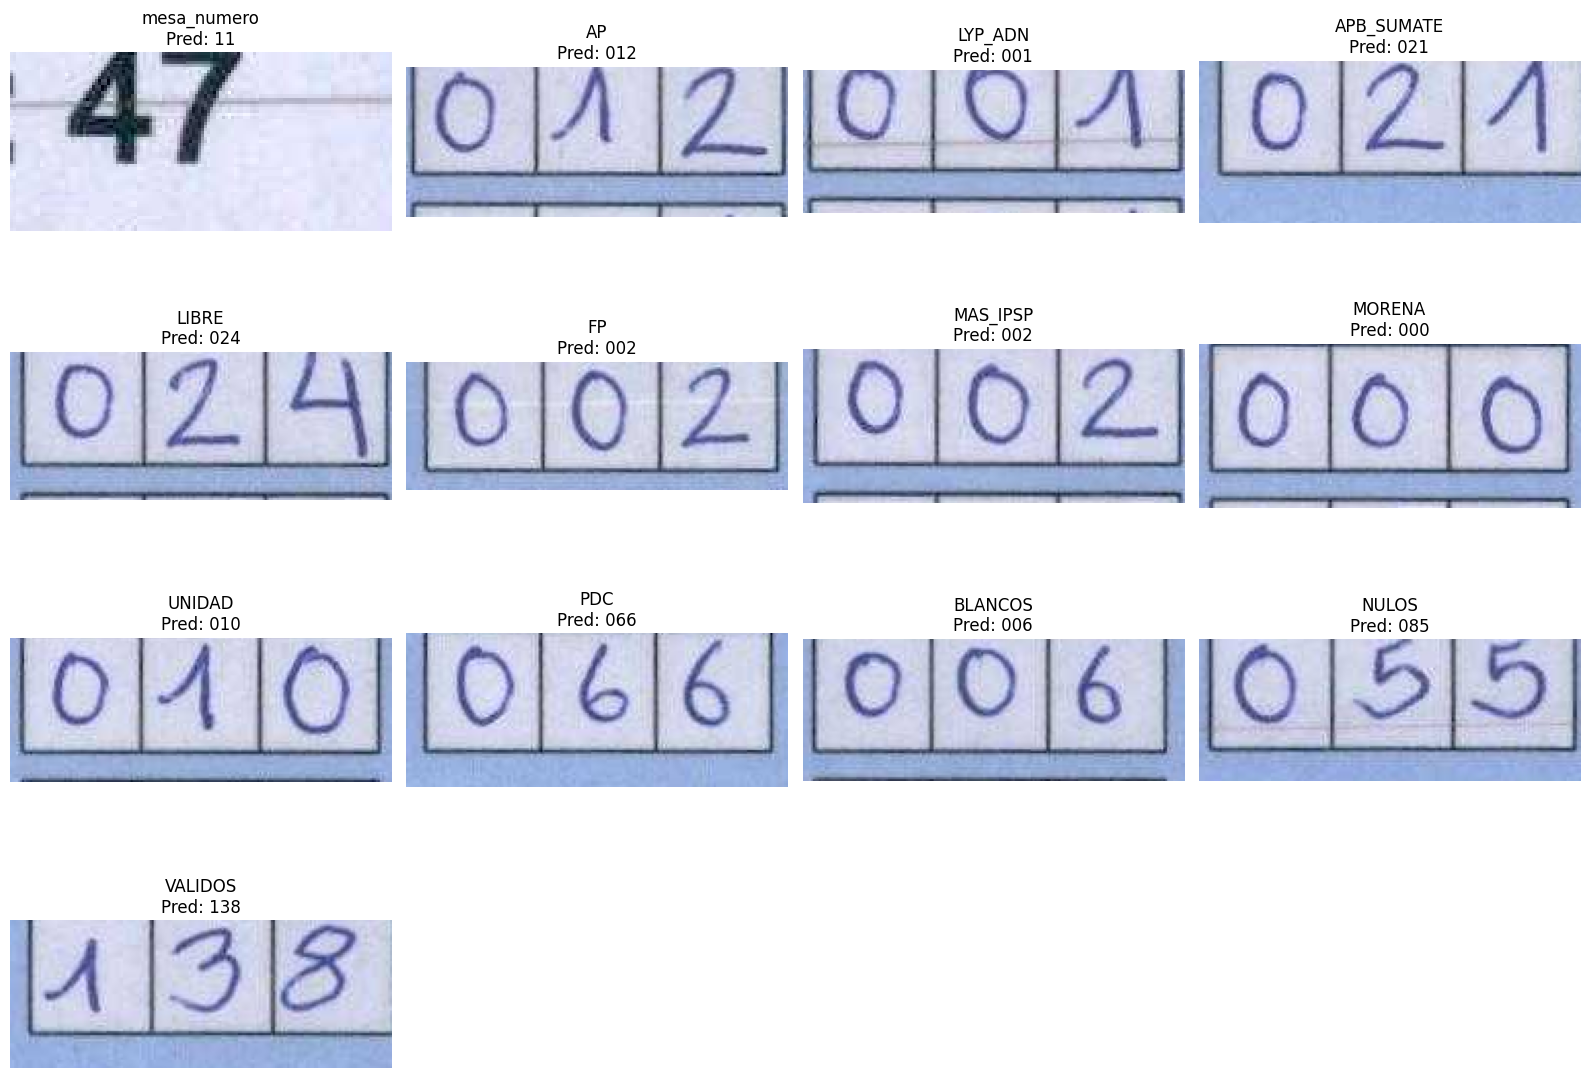

mesa_numero: 11
AP: 012
LYP_ADN: 001
APB_SUMATE: 021
LIBRE: 024
FP: 002
MAS_IPSP: 002
MORENA: 000
UNIDAD: 010
PDC: 066
BLANCOS: 006
NULOS: 085
VALIDOS: 138


In [44]:
import cv2, json
import matplotlib.pyplot as plt
import numpy as np
import torch

# Rutas
ruta_img = r"D:\POLLO\Actas_Final\mesa_47_3015071.jpg"
ruta_rois = r"D:\POLLO\rois_rel.json"

# Cargar imagen
img = cv2.imread(ruta_img)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_img}")
H, W = img.shape[:2]

# Cargar ROIs relativos
with open(ruta_rois, "r", encoding="utf-8") as f:
    rois_rel = json.load(f)["boxes"]

# -----------------------------
# Funciones auxiliares
# -----------------------------

def segment_digits_contours(roi, min_h_ratio=0.45, min_w_px=6, pad=2):
    """Segmenta dígitos pegados usando contornos (para mesa_numero)."""
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Hc, Wc = th.shape
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h >= min_h_ratio * Hc and w >= min_w_px:  # filtrar ruido
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])  # ordenar izquierda → derecha

    crops = []
    for (x, y, w, h) in boxes:
        x0 = max(x - pad, 0); y0 = max(y - pad, 0)
        x1 = min(x + w + pad, Wc); y1 = min(y + h + pad, Hc)
        crops.append(roi[y0:y1, x0:x1])
    return crops

def predict_fixed_boxes(roi, ndig=3):
    """Predice ROI con casillas fijas (ej: partidos)."""
    Hc, Wc = roi.shape[:2]
    ancho = max(1, Wc // ndig)
    pred = ""
    for i in range(ndig):
        sub = roi[:, i*ancho:(i+1)*ancho]
        if sub.size == 0:
            continue
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

def predict_sequence_roi(roi):
    """Predice ROI donde los dígitos están pegados (ej: mesa_numero)."""
    crops = segment_digits_contours(roi)
    if len(crops) == 0:
        crops = [roi]  # fallback
    pred = ""
    for sub in crops:
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

# -----------------------------
# Bucle principal
# -----------------------------

resultados = []
for nombre, (xr, yr, wr, hr) in rois_rel.items():
    x = int(xr * W)
    y = int(yr * H)
    w = int(wr * W)
    h = int(hr * H)
    roi = img[y:y+h, x:x+w]

    if roi.size == 0:
        pred = ""
    else:
        if nombre == "mesa_numero":   # <-- excepción
            pred = predict_sequence_roi(roi)
        else:
            pred = predict_fixed_boxes(roi, ndig=3)

    resultados.append((nombre, pred, roi))

# -----------------------------
# Mostrar resultados (excepto habilitados)
# -----------------------------
n = sum(1 for nombre, _, _ in resultados if nombre != "habilitados")
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 3*rows))

i = 0
for nombre, pred, roi in resultados:
    if nombre == "habilitados":
        continue  # <-- no mostrar este ROI
    plt.subplot(rows, cols, i+1)
    if roi.size != 0:
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title(f"{nombre}\nPred: {pred}")
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()

# Imprimir resultados (incluye habilitados)
for nombre, pred, _ in resultados:
    print(f"{nombre}: {pred}")



In [ ]:
# finetune_resnext_crnn_clean.py
# FINETUNE sobre modelo base ResNeXt + CRNN para dígitos
# Requiere: torch, torchvision, PIL, opencv-python, numpy, tqdm (opcional)

import os, glob, random, time, re
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as T
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
import cv2
from PIL import Image

try:
    from tqdm import tqdm
except:
    tqdm = lambda x, **k: x

# ------------------
# CONFIG (ajusta rutas)
# ------------------
DATA_TRAIN      = r"D:\POLLO\data\train"
DATA_VAL        = r"D:\POLLO\data\val"
DATA_FINET_REAL = r"D:\POLLO\DataTF\train"

CKPT_BEST_BASE  = r"D:\POLLO\resnext_ocr_best.pt"
CKPT_LAST_FINET = r"D:\POLLO\resnext_ocr_last_finetune.pt"
CKPT_BEST_FINET = r"D:\POLLO\resnext_ocr_best_finetune.pt"

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------
# HYPERPARAMS
# ------------------
BATCH_SIZE = 16
EPOCHS = 12
LR_FINET_HEAD = 5e-5
LR_FINET_BACKBONE = 2e-5
WD = 1e-4
ACCUM_STEPS = 2
AMP = True
CHANNELS_LAST = True
CLIP_NORM = 1.0

# ------------------
# CTC ALPHABET
# ------------------
DIGITS = "0123456789"
BLANK_IDX = 10
NCLASS = 11

cv2.setNumThreads(0)
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

# ------------------
# UTIL
# ------------------
def encode_text_to_ints(txt: str):
    s = re.sub(r"[^0-9]", "", txt or "")
    return [int(c) for c in s]

def read_pairs(folder: str):
    pairs = []
    if not os.path.exists(folder):
        return pairs
    for label in os.listdir(folder):
        label_dir = os.path.join(folder, label)
        if not os.path.isdir(label_dir):
            continue
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for fp in glob.glob(os.path.join(label_dir, ext)):
                pairs.append((fp, label))
    return pairs

# ------------------
# DATASET
# ------------------
class DigitsSeqDataset(Dataset):
    def __init__(self, root_dir: str):
        self.samples = read_pairs(root_dir)
        self.tfm = T.Compose([
            T.ToPILImage(),
            T.Resize((32,192)),
            T.ToTensor(),
            T.Normalize([0.5]*3,[0.5]*3)
        ])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        fp, lab = self.samples[i]
        img = cv2.imread(fp)
        if img is None:
            img = np.zeros((32,192,3), np.uint8)
        x = self.tfm(img)
        tgt = torch.tensor(encode_text_to_ints(lab), dtype=torch.long)
        return x, tgt, fp

def ctc_collate(batch):
    xs, tgts, fps = zip(*batch)
    xs = torch.stack(xs,0)
    tgt_lens = torch.tensor([t.numel() for t in tgts], dtype=torch.long)
    flat = torch.tensor([], dtype=torch.long)
    if any(t.numel()>0 for t in tgts):
        flat = torch.cat([t for t in tgts if t.numel()>0], dim=0)
    return xs, flat, tgt_lens, list(fps)

# ------------------
# MODELO
# ------------------
class CRNNHead(nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)
        x = x.permute(0,2,1)
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)

class ResNeXtOCR(nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):
    pred = logits.argmax(-1)
    seqs=[]
    for p in pred:
        last=-1; s=[]
        for t in p.tolist():
            if t!=BLANK_IDX and t!=last: s.append(DIGITS[t])
            last=t
        seqs.append("".join(s))
    return seqs

# ------------------
# DATALOADERS
# ------------------
ds_base = DigitsSeqDataset(DATA_TRAIN)
ds_val  = DigitsSeqDataset(DATA_VAL)
ds_fin_real = DigitsSeqDataset(DATA_FINET_REAL) if os.path.exists(DATA_FINET_REAL) else None

to_concat = [ds_base]
if ds_fin_real is not None and len(ds_fin_real)>0:
    to_concat.append(ds_fin_real)

train_ds = ConcatDataset(to_concat)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=ctc_collate)
val_dl   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=ctc_collate)

# ------------------
# MODELO + OPTIM
# ------------------
model = ResNeXtOCR().to(DEVICE)
if CHANNELS_LAST: model = model.to(memory_format=torch.channels_last)

if os.path.exists(CKPT_BEST_BASE):
    model.load_state_dict(torch.load(CKPT_BEST_BASE, map_location=DEVICE))
    print("✅ Cargado checkpoint base:", CKPT_BEST_BASE)
else:
    print("⚠️ No existe checkpoint base, entrenando desde cero")

for p in model.backbone.parameters(): p.requires_grad = False
for p in model.head.parameters(): p.requires_grad = True

opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINET_HEAD, weight_decay=WD)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=LR_FINET_HEAD*0.1)
ctc_loss = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)

# ------------------
# TRAIN LOOP FINETUNE
# ------------------
best_em_finet = -1.0
stalled = 0
patience = 3

print("Device:", DEVICE)
print("Start finetune loop")

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    running = 0.0
    step_accum = 0
    pbar = tqdm(enumerate(train_dl,1), total=len(train_dl), desc=f"Finetune Epoch {epoch}/{EPOCHS}")
    for i, (imgs, flat_targets, target_lengths, paths) in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        if CHANNELS_LAST: imgs = imgs.to(memory_format=torch.channels_last)
        flat_targets = flat_targets.to(DEVICE, non_blocking=True)
        target_lengths = target_lengths.to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=AMP):
            logits = model(imgs).log_softmax(-1)
            B,T,N = logits.shape
            input_lengths = torch.full((B,), T, dtype=torch.long, device=DEVICE)
            loss = ctc_loss(logits.permute(1,0,2), flat_targets, input_lengths, target_lengths)/ACCUM_STEPS

        scaler.scale(loss).backward()
        step_accum += 1
        if step_accum % ACCUM_STEPS == 0:
            if CLIP_NORM: 
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        running += loss.item()*ACCUM_STEPS
        if i % 50 == 0:
            pbar.set_postfix({"loss":f"{running/i:.4f}"})

    sched.step()

    # Unfreeze backbone después de 3 epochs
    if epoch == 4:
        print("🔓 Unfreezing backbone")
        for p in model.backbone.parameters(): p.requires_grad = True
        opt = torch.optim.AdamW([
            {"params": model.head.parameters(), "lr": LR_FINET_HEAD},
            {"params": model.backbone.parameters(), "lr": LR_FINET_BACKBONE}
        ], weight_decay=WD)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS-epoch+1, eta_min=LR_FINET_BACKBONE*0.1)
        scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    # VALIDACIÓN
    model.eval()
    total=0; exact=0
    with torch.no_grad():
        for imgs, flat_targets, target_lengths, paths in val_dl:
            imgs = imgs.to(DEVICE, non_blocking=True)
            if CHANNELS_LAST: imgs = imgs.to(memory_format=torch.channels_last)
            logits = model(imgs).log_softmax(-1)
            preds = ctc_greedy_decode(logits.cpu())

            idx=0; gts=[]
            for L in target_lengths.tolist():
                seq = flat_targets[idx:idx+L].tolist(); idx+=L
                gts.append("".join(DIGITS[k] for k in seq))

            for p,g in zip(preds,gts):
                if g=="": continue
                total += 1
                exact += int(p==g)

    val_em = (exact/total) if total>0 else 0.0
    dt = time.time()-t0
    print(f"[Finetune] Epoch {epoch} | train_loss={running/len(train_dl):.4f} | val_EM={val_em:.4f} | {dt:.1f}s")

    # Guardado checkpoints
    torch.save(model.state_dict(), CKPT_LAST_FINET)
    if val_em > best_em_finet:
        best_em_finet = val_em
        torch.save(model.state_dict(), CKPT_BEST_FINET)
        print("✓ Guardado BEST FINETUNE checkpoint")
        stalled = 0
    else:
        stalled += 1
        if stalled >= patience:
            print("🚦 Early stopping: no hubo mejora en val_EM")
            break

print("Finetune terminado. Best EM finetune:", round(best_em_finet,4))


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_21524\3055843228.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP)


✅ Cargado checkpoint base: D:\POLLO\resnext_ocr_best.pt
Device: cuda
Start finetune loop


Finetune Epoch 1/12:   0%|          | 0/263 [00:00<?, ?it/s]C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_21524\3055843228.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
Finetune Epoch 1/12: 100%|██████████| 263/263 [01:21<00:00,  3.21it/s, loss=0.0153]


[Finetune] Epoch 1 | train_loss=0.0160 | val_EM=0.9420 | 103.1s
✓ Guardado BEST FINETUNE checkpoint


Finetune Epoch 2/12: 100%|██████████| 263/263 [00:15<00:00, 17.05it/s, loss=0.0141]


[Finetune] Epoch 2 | train_loss=0.0136 | val_EM=0.9710 | 15.5s
✓ Guardado BEST FINETUNE checkpoint


Finetune Epoch 3/12: 100%|██████████| 263/263 [00:15<00:00, 17.16it/s, loss=0.0153]


[Finetune] Epoch 3 | train_loss=0.0147 | val_EM=0.9565 | 15.4s


Finetune Epoch 4/12: 100%|██████████| 263/263 [00:15<00:00, 17.14it/s, loss=0.0158]
C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_21524\3055843228.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP)


🔓 Unfreezing backbone
[Finetune] Epoch 4 | train_loss=0.0178 | val_EM=0.9565 | 15.4s


Finetune Epoch 5/12: 100%|██████████| 263/263 [00:51<00:00,  5.13it/s, loss=0.0114]


[Finetune] Epoch 5 | train_loss=0.0112 | val_EM=0.9275 | 51.4s
🚦 Early stopping: no hubo mejora en val_EM
Finetune terminado. Best EM finetune: 0.971


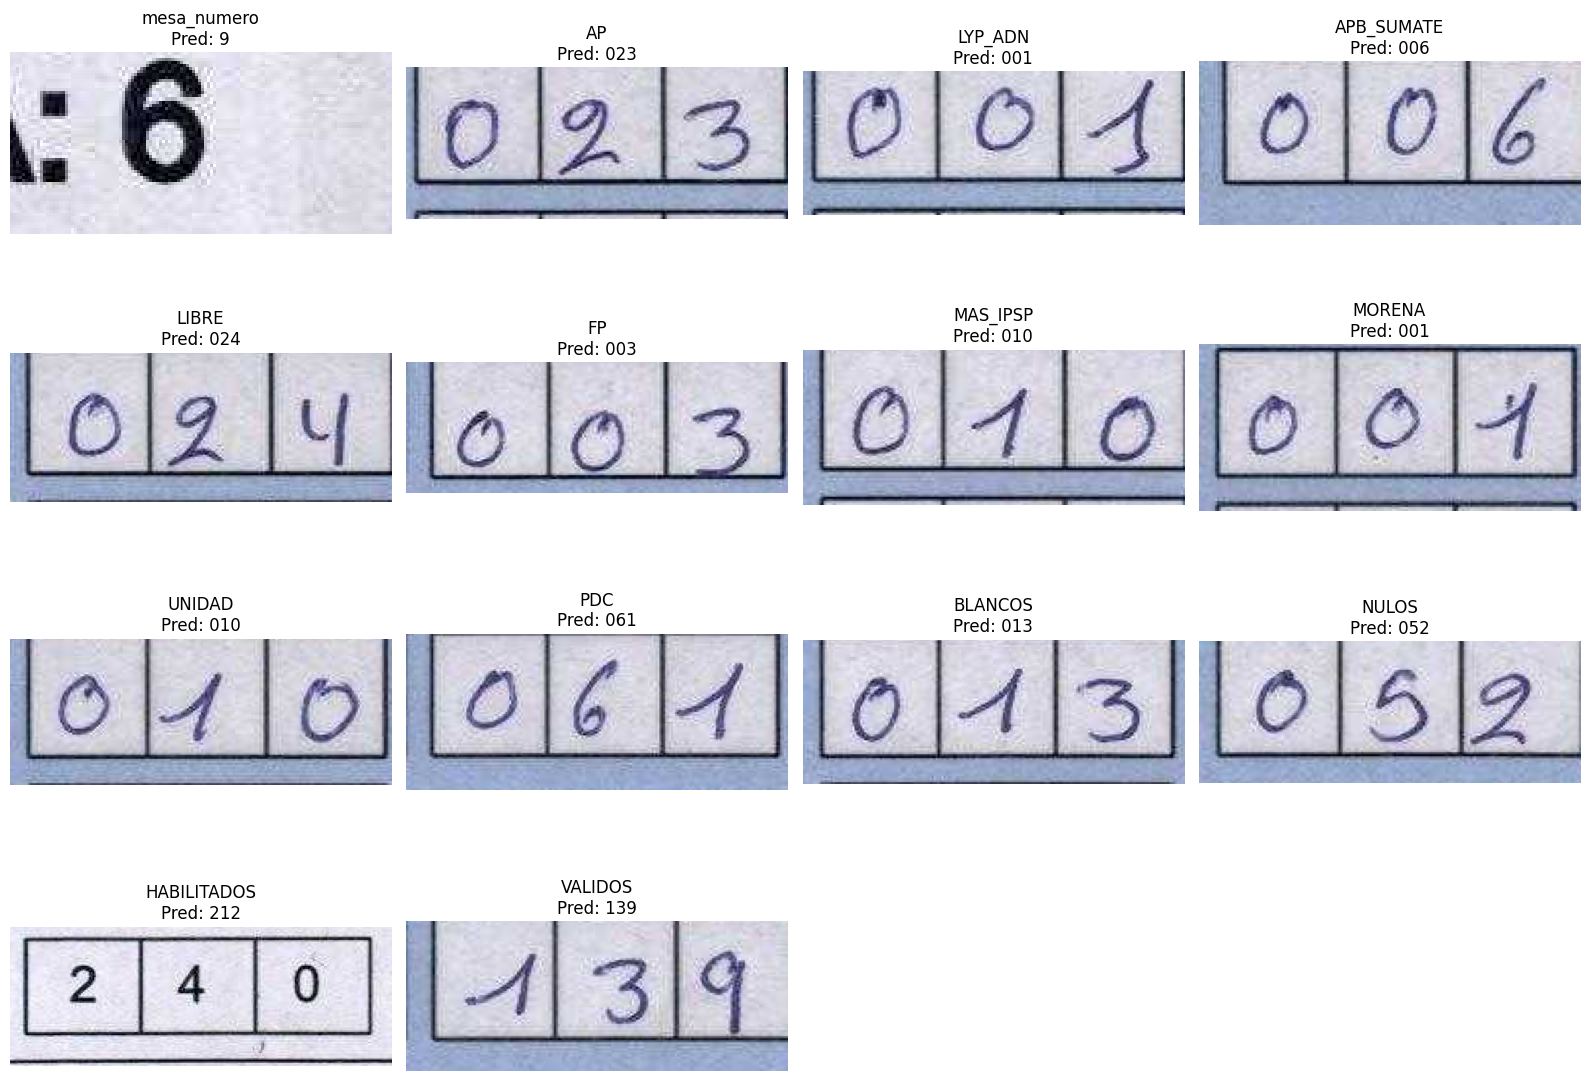

mesa_numero: 9
AP: 023
LYP_ADN: 001
APB_SUMATE: 006
LIBRE: 024
FP: 003
MAS_IPSP: 010
MORENA: 001
UNIDAD: 010
PDC: 061
BLANCOS: 013
NULOS: 052
HABILITADOS: 212
VALIDOS: 139


In [22]:
# -----------------------------
# PREDICCIÓN DE DÍGITOS CON FINETUNE (todo en un solo script)
# -----------------------------
import os, json, cv2, torch, numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

# -----------------------------
# Configuración
# -----------------------------
ruta_img = r"D:\POLLO\Actas_Final\mesa_6_1012701.jpg"
ruta_rois = r"D:\POLLO\rois_rel.json"
ckpt_finet = r"D:\POLLO\resnext_ocr_best_finetune.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# CTC y dígitos
# -----------------------------
NCLASS = 11
BLANK_IDX = 10
DIGITS = "0123456789"

# -----------------------------
# Modelo
# -----------------------------
class CRNNHead(nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)
        x = x.permute(0,2,1)
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)

class ResNeXtOCR(nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):
    pred = logits.argmax(-1)
    seqs=[]
    for p in pred:
        last=-1; s=[]
        for t in p.tolist():
            if t!=BLANK_IDX and t!=last: s.append(DIGITS[t])
            last=t
        seqs.append("".join(s))
    return seqs

# -----------------------------
# Transformación de imágenes
# -----------------------------
tfm = T.Compose([
    T.ToPILImage(),
    T.Resize((32,192)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# -----------------------------
# Funciones auxiliares
# -----------------------------
def segment_digits_contours(roi, min_h_ratio=0.45, min_w_px=6, pad=2):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Hc, Wc = th.shape
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h >= min_h_ratio * Hc and w >= min_w_px:
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])

    crops = []
    for (x, y, w, h) in boxes:
        x0 = max(x - pad, 0); y0 = max(y - pad, 0)
        x1 = min(x + w + pad, Wc); y1 = min(y + h + pad, Hc)
        crops.append(roi[y0:y1, x0:x1])
    return crops

def predict_fixed_boxes(roi, ndig=3):
    Hc, Wc = roi.shape[:2]
    ancho = max(1, Wc // ndig)
    pred = ""
    for i in range(ndig):
        sub = roi[:, i*ancho:(i+1)*ancho]
        if sub.size == 0: continue
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

def predict_sequence_roi(roi):
    crops = segment_digits_contours(roi)
    if len(crops) == 0: crops = [roi]
    pred = ""
    for sub in crops:
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

# -----------------------------
# Cargar modelo finetuneado
# -----------------------------
model = ResNeXtOCR(nclass=NCLASS).to(DEVICE)
model.load_state_dict(torch.load(ckpt_finet, map_location=DEVICE))
model.eval()
model = model.to(memory_format=torch.channels_last)

# -----------------------------
# Cargar imagen y ROIs
# -----------------------------
img = cv2.imread(ruta_img)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_img}")
H, W = img.shape[:2]

with open(ruta_rois, "r", encoding="utf-8") as f:
    rois_rel = json.load(f)["boxes"]

# -----------------------------
# Predicción
# -----------------------------
resultados = []
for nombre, (xr, yr, wr, hr) in rois_rel.items():
    x = int(xr * W)
    y = int(yr * H)
    w = int(wr * W)
    h = int(hr * H)
    roi = img[y:y+h, x:x+w]

    if roi.size == 0:
        pred = ""
    else:
        if nombre == "mesa_numero":
            pred = predict_sequence_roi(roi)
        else:
            pred = predict_fixed_boxes(roi, ndig=3)

    resultados.append((nombre, pred, roi))

# -----------------------------
# Mostrar resultados
# -----------------------------
n = len(resultados)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 3*rows))
for i, (nombre, pred, roi) in enumerate(resultados):
    plt.subplot(rows, cols, i+1)
    if roi.size != 0:
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title(f"{nombre}\nPred: {pred}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# Imprimir resultados
# -----------------------------
for nombre, pred, _ in resultados:
    print(f"{nombre}: {pred}")


CARGA DE LA IMAGEN CASI FINAL PARA SUMATORIA DE VOTOS VALIDOS 

In [24]:
# -----------------------------
# PREDICCIÓN DE DÍGITOS CON FINETUNE (resumen de sumatoria)
# -----------------------------
import os, json, cv2, torch, numpy as np
import torchvision.transforms as T
import torch.nn as nn
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

# -----------------------------
# Configuración
# -----------------------------
ruta_img = r"D:\POLLO\Actas_Final\mesa_6_1012701.jpg"
ruta_rois = r"D:\POLLO\rois_rel.json"
ckpt_finet = r"D:\POLLO\resnext_ocr_best_finetune.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# CTC y dígitos
# -----------------------------
NCLASS = 11
BLANK_IDX = 10
DIGITS = "0123456789"

# -----------------------------
# Modelo
# -----------------------------
class CRNNHead(nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)
        x = x.permute(0,2,1)
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)

class ResNeXtOCR(nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):
    pred = logits.argmax(-1)
    seqs=[]
    for p in pred:
        last=-1; s=[]
        for t in p.tolist():
            if t!=BLANK_IDX and t!=last: s.append(DIGITS[t])
            last=t
        seqs.append("".join(s))
    return seqs

# -----------------------------
# Transformación de imágenes
# -----------------------------
tfm = T.Compose([
    T.ToPILImage(),
    T.Resize((32,192)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# -----------------------------
# Funciones auxiliares
# -----------------------------
def segment_digits_contours(roi, min_h_ratio=0.45, min_w_px=6, pad=2):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Hc, Wc = th.shape
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h >= min_h_ratio * Hc and w >= min_w_px:
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])

    crops = []
    for (x, y, w, h) in boxes:
        x0 = max(x - pad, 0); y0 = max(y - pad, 0)
        x1 = min(x + w + pad, Wc); y1 = min(y + h + pad, Hc)
        crops.append(roi[y0:y1, x0:x1])
    return crops

def predict_fixed_boxes(roi, ndig=3):
    Hc, Wc = roi.shape[:2]
    ancho = max(1, Wc // ndig)
    pred = ""
    for i in range(ndig):
        sub = roi[:, i*ancho:(i+1)*ancho]
        if sub.size == 0: continue
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

def predict_sequence_roi(roi):
    crops = segment_digits_contours(roi)
    if len(crops) == 0: crops = [roi]
    pred = ""
    for sub in crops:
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

# -----------------------------
# Cargar modelo finetuneado
# -----------------------------
model = ResNeXtOCR(nclass=NCLASS).to(DEVICE)
model.load_state_dict(torch.load(ckpt_finet, map_location=DEVICE))
model.eval()
model = model.to(memory_format=torch.channels_last)

# -----------------------------
# Cargar imagen y ROIs
# -----------------------------
img = cv2.imread(ruta_img)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_img}")
H, W = img.shape[:2]

with open(ruta_rois, "r", encoding="utf-8") as f:
    rois_rel = json.load(f)["boxes"]

# -----------------------------
# Predicción y sumatoria
# -----------------------------
total_votos = {}  # diccionario acumulado

for nombre, (xr, yr, wr, hr) in rois_rel.items():
    x = int(xr * W)
    y = int(yr * H)
    w = int(wr * W)
    h = int(hr * H)
    roi = img[y:y+h, x:x+w]

    if roi.size == 0:
        pred = ""
    else:
        if nombre == "mesa_numero":
            pred = predict_sequence_roi(roi)
        else:
            pred = predict_fixed_boxes(roi, ndig=3)

    # Acumular resultados
    if nombre not in total_votos:
        total_votos[nombre] = 0
    try:
        total_votos[nombre] += int(pred)
    except:
        pass  # en caso de predicción vacía o no numérica

# -----------------------------
# Mostrar sumatoria final
# -----------------------------
print("===== RESUMEN DE VOTOS =====")
for k, v in total_votos.items():
    print(f"{k}: {v}")


===== RESUMEN DE VOTOS =====
mesa_numero: 9
AP: 23
LYP_ADN: 1
APB_SUMATE: 6
LIBRE: 24
FP: 3
MAS_IPSP: 10
MORENA: 1
UNIDAD: 10
PDC: 61
BLANCOS: 13
NULOS: 52
HABILITADOS: 212
VALIDOS: 139


In [37]:
import os, json, sqlite3
import cv2, torch, torch.nn as nn, torchvision.transforms as T
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
ruta_img = r"D:\POLLO\Actas_Final\mesa_30_3017171.jpg"
ruta_rois = r"D:\POLLO\rois_rel.json"
ckpt_finet = r"D:\POLLO\resnext_ocr_best_finetune.pt"  # checkpoint finetuneado

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# ALFABETO / CTC
# -----------------------------
DIGITS = "0123456789"
BLANK_IDX = 10
NCLASS = 11

# -----------------------------
# TRANSFORMACIÓN
# -----------------------------
tfm = T.Compose([
    T.ToPILImage(),
    T.Resize((32, 192)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# -----------------------------
# MODELO
# -----------------------------
class CRNNHead(nn.Module):
    def __init__(self, c_in=2048, hidden=256, nclass=NCLASS):
        super().__init__()
        self.l1 = nn.LSTM(c_in, hidden, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(2*hidden, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden, nclass)
    def forward(self, feat):
        x = feat.mean(dim=2)
        x = x.permute(0,2,1)
        x,_ = self.l1(x); x,_ = self.l2(x)
        return self.fc(x)

from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
class ResNeXtOCR(nn.Module):
    def __init__(self, nclass=NCLASS):
        super().__init__()
        base = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.head = CRNNHead(2048, 256, nclass)
    def forward(self, x):
        return self.head(self.backbone(x))

def ctc_greedy_decode(logits):
    pred = logits.argmax(-1)
    seqs=[]
    for p in pred:
        last=-1; s=[]
        for t in p.tolist():
            if t!=BLANK_IDX and t!=last: s.append(DIGITS[t])
            last=t
        seqs.append("".join(s))
    return seqs

# -----------------------------
# CARGAR MODELO
# -----------------------------
model = ResNeXtOCR(nclass=NCLASS).to(DEVICE)
model.load_state_dict(torch.load(ckpt_finet, map_location=DEVICE))
model.eval()

# -----------------------------
# FUNCIONES DE PREDICCIÓN
# -----------------------------
def segment_digits_contours(roi, min_h_ratio=0.45, min_w_px=6, pad=2):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Hc, Wc = th.shape
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h >= min_h_ratio * Hc and w >= min_w_px:
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])
    crops = []
    for (x, y, w, h) in boxes:
        x0 = max(x - pad, 0); y0 = max(y - pad, 0)
        x1 = min(x + w + pad, Wc); y1 = min(y + h + pad, Hc)
        crops.append(roi[y0:y1, x0:x1])
    return crops

def predict_fixed_boxes(roi, ndig=3):
    Hc, Wc = roi.shape[:2]
    ancho = max(1, Wc // ndig)
    pred = ""
    for i in range(ndig):
        sub = roi[:, i*ancho:(i+1)*ancho]
        if sub.size == 0: continue
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

def predict_sequence_roi(roi):
    crops = segment_digits_contours(roi)
    if len(crops) == 0:
        crops = [roi]
    pred = ""
    for sub in crops:
        x_in = tfm(sub).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x_in).log_softmax(-1)
            pred += ctc_greedy_decode(logits.cpu())[0]
    return pred

# -----------------------------
# CARGAR IMAGEN Y ROIS
# -----------------------------
img = cv2.imread(ruta_img)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_img}")
H, W = img.shape[:2]

with open(ruta_rois, "r", encoding="utf-8") as f:
    rois_rel = json.load(f)["boxes"]

# -----------------------------
# PREDICCIÓN DE TODOS LOS CAMPOS
# -----------------------------
resultados = []
for nombre, (xr, yr, wr, hr) in rois_rel.items():
    x = int(xr * W); y = int(yr * H)
    w = int(wr * W); h = int(hr * H)
    roi = img[y:y+h, x:x+w]
    if roi.size == 0:
        pred = ""
    else:
        if nombre == "mesa_numero":
            pred = predict_sequence_roi(roi)
        else:
            pred = predict_fixed_boxes(roi, ndig=3)
    resultados.append((nombre, pred))

# -----------------------------
# SUMATORIA DE VOTOS
# -----------------------------
votos = {nombre: int(pred) if pred.isdigit() else 0 for nombre, pred in resultados}

# Calcular VALIDOS
votos["VALIDOS"] = sum(votos.get(k,0) for k in votos if k not in ["HABILITADOS","BLANCOS","NULOS","mesa_numero"])

# -----------------------------
# GUARDAR EN SQLITE
# -----------------------------
conn = sqlite3.connect("votosN.db")
c = conn.cursor()
# Crear tabla si no existe
campos = ", ".join([f"{k} INTEGER" for k in votos.keys()])
c.execute(f"CREATE TABLE IF NOT EXISTS resultados ({campos})")
# Insertar fila
cols = ", ".join(votos.keys())
placeholders = ", ".join("?"*len(votos))
c.execute(f"INSERT INTO resultados ({cols}) VALUES ({placeholders})", list(votos.values()))
conn.commit()
conn.close()

# -----------------------------
# IMPRIMIR RESULTADOS
# -----------------------------
for k,v in votos.items():
    print(f"{k}: {v}")


mesa_numero: 21
AP: 27
LYP_ADN: 4
APB_SUMATE: 15
LIBRE: 16
FP: 4
MAS_IPSP: 4
MORENA: 0
UNIDAD: 14
PDC: 60
BLANCOS: 7
NULOS: 60
HABILITADOS: 212
VALIDOS: 288


In [38]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("votosN.db")
df = pd.read_sql_query("SELECT * FROM resultados", conn)
print(df)
conn.close()

   mesa_numero  AP  LYP_ADN  APB_SUMATE  LIBRE  FP  MAS_IPSP  MORENA  UNIDAD  \
0           21  27        4          15     16   4         4       0      14   

   PDC  BLANCOS  NULOS  HABILITADOS  VALIDOS  
0   60        7     60          212      288  
